In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
chunklist = []
for chunk in pd.read_csv('data_strat_sample.csv', chunksize = 100000):
    chunklist.append(chunk)

df = pd.concat(chunklist)


CPU times: user 42.1 s, sys: 13.7 s, total: 55.8 s
Wall time: 57.6 s


In [3]:
df.columns

Index(['VendorID', 'pickup', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'PULocationID',
       'DOLocationID', 'tempm', 'dewptm', 'hum', 'wspdi', 'wgusti', 'visi',
       'pressurem', 'windchillm', 'heatindexm', 'precipm', 'conds', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado'],
      dtype='object')

In [4]:
df['pickup'] = pd.to_datetime(df.pickup)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

In [5]:
df['trip_time'] = df.tpep_dropoff_datetime - df.pickup

In [6]:
df['trip_time'] = df.trip_time.dt.total_seconds() / 3600

In [7]:
df['trip_time'].describe()

count    6.108450e+06
mean     2.366994e-01
std      2.637137e+00
min     -1.825355e+03
25%      1.105556e-01
50%      1.858333e-01
75%      3.033333e-01
max      3.157866e+03
Name: trip_time, dtype: float64

In [8]:
df.trip_distance.describe()

count    6.108450e+06
mean     3.415695e+00
std      6.977148e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.700000e+00
75%      3.100000e+00
max      1.587540e+06
Name: trip_distance, dtype: float64

In [9]:
df['avg_speed'] = df.trip_distance / df.trip_time

In [10]:
df.avg_speed.describe()

count    6.094938e+06
mean              inf
std               NaN
min     -1.809000e+03
25%      7.309645e+00
50%      1.005587e+01
75%      1.381663e+01
max               inf
Name: avg_speed, dtype: float64

In [11]:
df[df.avg_speed == float('inf')].head()

,VendorID,pickup,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,precipm,conds,fog,rain,snow,hail,thunder,tornado,trip_time,avg_speed
14799,1,2016-02-03 13:57:44,2016-02-03 13:57:44,1,2.5,-73.958679,40.780861,1,Y,-73.958679,...,2.3,Light Rain,0,1,0,0,0,0,0.0,inf
17903,1,2016-02-05 01:41:42,2016-02-05 01:41:42,1,0.7,-74.003883,40.742310,1,N,-74.003883,...,0.0,Light Rain,0,1,0,0,0,0,0.0,inf
62433,1,2016-04-02 10:57:03,2016-04-02 10:57:03,1,22.8,-74.004288,40.721195,1,N,-74.004288,...,1.3,Light Rain,0,1,0,0,0,0,0.0,inf
379757,1,2016-01-05 14:35:57,2016-01-05 14:35:57,1,2.2,-74.004387,40.741909,1,Y,-74.004387,...,NaN,Clear,0,0,0,0,0,0,0.0,inf
388824,1,2016-01-05 20:50:19,2016-01-05 20:50:19,1,4.5,-73.964493,40.770348,1,N,-73.964493,...,NaN,Clear,0,0,0,0,0,0,0.0,inf


### Delete the rows that have inf avg_speed.

In [12]:
df = df[df.avg_speed != float('inf')]

### Drop the rows that have NAN avg_speed.

In [13]:
df.dropna(subset = ['avg_speed'], inplace = True)

In [14]:
# size of the df should match the count of the avg speed column
len(df)

6094857

In [15]:
df.avg_speed.describe()

count    6.094857e+06
mean     1.725925e+02
std      3.858297e+05
min     -1.809000e+03
25%      7.309645e+00
50%      1.005587e+01
75%      1.381663e+01
max      9.525240e+08
Name: avg_speed, dtype: float64

In [16]:
lower_speed, upper_speed = np.quantile(df.avg_speed, [.025, .975])

In [17]:
lower_speed, upper_speed

(3.432657926102504, 28.725065047701648)

### Let's keep only the speeds that lay within 2 standard deviations to simulate taxi rides within the city.

In [18]:
df = df[(df.avg_speed >= lower_speed) & (df.avg_speed <= upper_speed)]

In [19]:
df.avg_speed.describe()

count    5.790100e+06
mean     1.106771e+01
std      4.967930e+00
min      3.432790e+00
25%      7.452229e+00
50%      1.005587e+01
75%      1.355155e+01
max      2.872507e+01
Name: avg_speed, dtype: float64

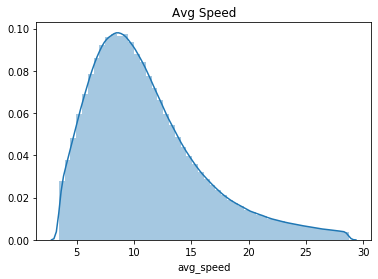

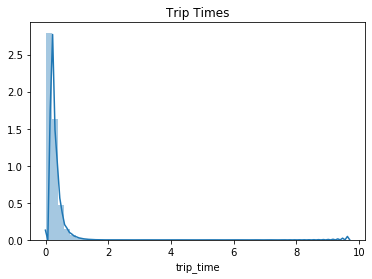

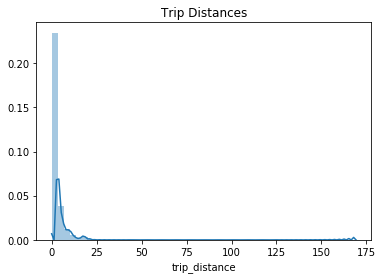

In [20]:
sns.distplot(df.avg_speed)
plt.title('Avg Speed')
plt.show()
sns.distplot(df.trip_time)
plt.title('Trip Times')
plt.show()
sns.distplot(df.trip_distance)
plt.title('Trip Distances')
plt.show()

The distributions of trip times and distances have a heavy right skew which seems expected but the values do not seem to be outrageous.  We would expect the majority of taxi rides in NYC to be of short distances.  The distribution of the average speeds also has a slight right skew

## Explore some more of the columns

In [21]:
df.columns

Index(['VendorID', 'pickup', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'PULocationID',
       'DOLocationID', 'tempm', 'dewptm', 'hum', 'wspdi', 'wgusti', 'visi',
       'pressurem', 'windchillm', 'heatindexm', 'precipm', 'conds', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'trip_time', 'avg_speed'],
      dtype='object')

In [22]:
df.VendorID.value_counts()

1    5790100
Name: VendorID, dtype: int64

In [23]:
df.passenger_count.value_counts()

1    4688251
2     785958
3     200417
4     111098
5       3120
6       1207
0         43
7          4
9          2
Name: passenger_count, dtype: int64

In [24]:
df.RatecodeID.value_counts()

1     5694395
2       82539
5        6132
3        5728
4        1227
99         64
6          15
Name: RatecodeID, dtype: int64

In [25]:
df.store_and_fwd_flag.value_counts()

N    5722143
Y      67957
Name: store_and_fwd_flag, dtype: int64

In [26]:
df.payment_type.value_counts()

1    3824809
2    1917572
3      34608
4      13111
Name: payment_type, dtype: int64

In [27]:
df.visi.describe()

count    5.634997e+06
mean     8.884866e+00
std      2.019603e+00
min      2.000000e-01
25%      8.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: visi, dtype: float64

In [28]:
df.rain.value_counts()

0    5531312
1     258788
Name: rain, dtype: int64

In [29]:
df.snow.value_counts()

0    5754626
1      35474
Name: snow, dtype: int64

In [30]:
df.hail.value_counts()

0    5790100
Name: hail, dtype: int64

In [31]:
df.tornado.value_counts()

0    5790100
Name: tornado, dtype: int64

In [32]:
df.thunder.value_counts()

0    5790100
Name: thunder, dtype: int64

In [33]:
df.fog.value_counts()

0    5779466
1      10634
Name: fog, dtype: int64

In [34]:
df.conds.value_counts()

Clear                  2892717
Overcast               1338550
Mostly Cloudy           403926
Partly Cloudy           331827
Scattered Clouds        220456
Light Rain              201309
Unknown                 186675
Haze                    120746
Rain                     38571
Light Snow               27674
Heavy Rain               16933
Snow                      7539
Light Freezing Rain       1975
Fog                        941
Heavy Snow                 261
Name: conds, dtype: int64

In [35]:
df.hum.describe()

count    5.788217e+06
mean     5.757377e+01
std      1.942193e+01
min      9.000000e+00
25%      4.300000e+01
50%      5.500000e+01
75%      7.300000e+01
max      1.000000e+02
Name: hum, dtype: float64

### Drop the columns that do not seem to be of value.  
### VendorID, store_and_fwd_flag, hail, tornado, thunder, tpep_dropoff_datetime

In [36]:
df.drop(columns = ['VendorID', 'store_and_fwd_flag', 'hail', 'tornado', 'thunder', 'tpep_dropoff_datetime'], 
        inplace = True)

In [37]:
df.columns

Index(['pickup', 'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'PULocationID', 'DOLocationID', 'tempm', 'dewptm', 'hum', 'wspdi',
       'wgusti', 'visi', 'pressurem', 'windchillm', 'heatindexm', 'precipm',
       'conds', 'fog', 'rain', 'snow', 'trip_time', 'avg_speed'],
      dtype='object')

In [38]:
df = df[['pickup', 'trip_time', 'trip_distance', 'avg_speed', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'dropoff_longitude',
       'dropoff_latitude', 'PULocationID', 'DOLocationID', 'tempm', 'dewptm', 'hum', 'wspdi',
       'wgusti', 'visi', 'pressurem', 'windchillm', 'heatindexm', 'precipm',
       'conds', 'fog', 'rain', 'snow',  'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']]

In [39]:
df.head()

,pickup,trip_time,trip_distance,avg_speed,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,...,rain,snow,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2016-01-09 12:23:30,0.271667,1.7,6.257669,1,-74.001114,40.757141,1,-73.983444,40.758621,...,1,0,2,11.0,0.0,0.5,0.00,0.0,0.3,11.80
1,2016-01-09 12:54:35,0.065556,0.5,7.627119,1,-73.996094,40.743328,1,-73.991898,40.744148,...,1,0,2,4.5,0.0,0.5,0.00,0.0,0.3,5.30
2,2016-01-09 12:31:37,0.130278,1.1,8.443497,1,0.000000,0.000000,1,0.000000,0.000000,...,1,0,1,7.5,0.0,0.5,2.45,0.0,0.3,10.75
3,2016-01-09 12:31:20,0.143611,1.2,8.355899,3,-73.989899,40.737572,1,-73.997131,40.724930,...,1,0,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35
4,2016-01-09 13:02:38,0.258333,3.1,12.000000,2,-73.972809,40.765129,1,-73.983253,40.730530,...,1,0,2,13.0,0.0,0.5,0.00,0.0,0.3,13.80


In [40]:
df.dropoff_longitude.count()

3094027

In [41]:
df.PULocationID.count()

2696073

In [42]:
len(df)

5790100

### Since the longitutde/latitude info and the LocationID do not show up in the dataset at the same dates, we decided to exclude it from this analysis.

In [43]:
df.drop(columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                   'PULocationID', 'DOLocationID'], inplace = True)

In [44]:
df.columns

Index(['pickup', 'trip_time', 'trip_distance', 'avg_speed', 'passenger_count',
       'RatecodeID', 'tempm', 'dewptm', 'hum', 'wspdi', 'wgusti', 'visi',
       'pressurem', 'windchillm', 'heatindexm', 'precipm', 'conds', 'fog',
       'rain', 'snow', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')

### Let's also create a tip_p column for the tip as a percentage of the total charge.

In [45]:
df[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']].head()

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,11.0,0.0,0.5,0.00,0.0,0.3,11.80
1,4.5,0.0,0.5,0.00,0.0,0.3,5.30
2,7.5,0.0,0.5,2.45,0.0,0.3,10.75
3,7.0,0.0,0.5,1.55,0.0,0.3,9.35
4,13.0,0.0,0.5,0.00,0.0,0.3,13.80


In [46]:
df['tip_p'] = df.tip_amount / (df.fare_amount + df.extra + df.mta_tax + df.tolls_amount + df.improvement_surcharge)

In [47]:
df.tip_p.describe()

count    5.790036e+06
mean     1.256121e-01
std      8.511526e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.530612e-01
75%      1.992754e-01
max      8.333333e+02
Name: tip_p, dtype: float64

### There are some entries where the tip percentage is nan because the total amount charged is 0 and the tip is 0, so 0/0 gives us a nan value.  Since there is no tip or charge we can just replace these empty values with 0.

In [48]:
df.fillna(value = {'tip_p':0}, inplace = True)

In [49]:
df.tip_p.describe()

count    5.790100e+06
mean     1.256107e-01
std      8.511480e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.530612e-01
75%      1.992754e-01
max      8.333333e+02
Name: tip_p, dtype: float64

In [50]:
df.head()

,pickup,trip_time,trip_distance,avg_speed,passenger_count,RatecodeID,tempm,dewptm,hum,wspdi,...,snow,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_p
0,2016-01-09 12:23:30,0.271667,1.7,6.257669,1,1,7.8,4.4,79.0,5.8,...,0,2,11.0,0.0,0.5,0.00,0.0,0.3,11.80,0.000000
1,2016-01-09 12:54:35,0.065556,0.5,7.627119,1,1,7.8,4.4,79.0,5.8,...,0,2,4.5,0.0,0.5,0.00,0.0,0.3,5.30,0.000000
2,2016-01-09 12:31:37,0.130278,1.1,8.443497,1,1,7.8,4.4,79.0,5.8,...,0,1,7.5,0.0,0.5,2.45,0.0,0.3,10.75,0.295181
3,2016-01-09 12:31:20,0.143611,1.2,8.355899,3,1,7.8,4.4,79.0,5.8,...,0,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35,0.198718
4,2016-01-09 13:02:38,0.258333,3.1,12.000000,2,1,7.8,4.4,79.0,5.8,...,0,2,13.0,0.0,0.5,0.00,0.0,0.3,13.80,0.000000


In [51]:
df.sort_values(by = ['pickup'], inplace = True)

In [52]:
df.tail()

,pickup,trip_time,trip_distance,avg_speed,passenger_count,RatecodeID,tempm,dewptm,hum,wspdi,...,snow,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_p
6107593,2016-12-31 23:57:58,0.106389,0.6,5.639687,1,1,6.7,-4.4,45.0,4.6,...,0,2,6.0,0.5,0.5,0.0,0.0,0.3,7.3,0.000000
6108277,2016-12-31 23:58:05,0.081111,1.0,12.328767,1,1,6.7,-4.4,45.0,4.6,...,0,1,5.5,0.5,0.5,1.0,0.0,0.3,7.8,0.147059
6105331,2016-12-31 23:58:50,0.304444,3.0,9.854015,4,1,6.7,-4.4,45.0,4.6,...,0,2,14.0,0.5,0.5,0.0,0.0,0.3,15.3,0.000000
6107483,2016-12-31 23:59:25,0.053333,0.4,7.500000,1,1,6.7,-4.4,45.0,4.6,...,0,1,4.0,0.5,0.5,0.2,0.0,0.3,5.5,0.037736
6101737,2016-12-31 23:59:27,0.208056,1.9,9.132176,1,1,6.7,-4.4,45.0,4.6,...,0,1,10.0,0.5,0.5,2.5,0.0,0.3,13.8,0.221239


## We should convert the categorical variables into binary or dummy variables.

In [53]:
#create dummies for weather conditions
dummy = pd.get_dummies(df.conds)

In [54]:
df = pd.concat([df, dummy], axis = 1)

In [55]:
df.rename(columns = {'Heavy Rain':'Heavy_Rain', 'Heavy Snow': 'Heavy_Snow', 
                     'Light Freezing Rain': 'Light_Freezing_Rain', 'Light Rain':'Light_Rain', 
                     'Light Snow':'Light_Snow', 'Mostly Cloudy':'Mostly_Cloudy', 'Partly Cloudy':'Partly_Cloudy', 
                     'Scattered Clouds':'Scattered_Clouds' }, inplace = True)

In [56]:
#create dummies for payment type
dummy = pd.get_dummies(df.payment_type)
dummy.rename(columns = {1:'payment_type_1_creditcard', 2:'payment_type_2_cash', 3:'payment_type_3_nocharge', 4:'payment_type_4_dispute'}, inplace = True)


In [57]:
df = pd.concat([df, dummy], axis = 1)

In [58]:
df.drop(columns = ['payment_type'], inplace = True)

In [59]:
#create dummy for rate codes
dummy = pd.get_dummies(df.RatecodeID)
dummy.rename(columns = {1:'ratecode_1', 2:'ratecode_2', 3:'ratecode_3', 4:'ratecode_4', 5:'ratecode_5', 6:'ratecode_6', 99:'ratecode_99'}, inplace = True)

In [60]:
df = pd.concat([df, dummy], axis = 1)

## From the pickup datetimes, let's extract more features such as the month and the day

In [61]:
df['month'] = df.pickup.dt.month
df['day'] = df.pickup.dt.day
df['weekday'] = df.pickup.dt.dayofweek
df['hour'] = df.pickup.dt.hour

In [65]:
df.to_csv('capstone_data.csv', index = False)